In [1]:
from pathlib import Path
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from light_by_light.utils import read_yaml, write_yaml

from lbl_botorch.evaluate_trial import lbl_evaluation
from lbl_botorch.optimization import (run_axclient_optimization,
                                      run_axclient_optimization_batch)
from lbl_botorch.utils import (load_json_object, get_model_from_experiment,
                               gather_trials_data)

from ax.plot.contour import plot_contour
from ax.utils.notebook.plotting import init_notebook_plotting, render
from ax.plot.slice import plot_slice, plot_slice_plotly
from ax.plot.contour import plot_contour
from ax.service.ax_client import AxClient, ObjectiveProperties

init_notebook_plotting()
import plotly.io as pio
# pio.renderers.default = "png"
pio.renderers.default = "jupyterlab"

home_path = '/home/wi73yus/light-by-light-botorch'
work_path = '/work/wi73yus/lbl-botorch-experiments'

/home/wi73yus/.conda/envs/lbl-botorch-test/lib/python3.10/site-packages/pyfftw/interfaces/__init__.py:268: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  has_scipy_fft = _LooseVersion(scipy.__version__) >= _LooseVersion('1.4.0')


[INFO 05-13 15:19:22] ax.utils.notebook.plotting: Injecting Plotly library into cell. Do not overwrite or delete cell.
[INFO 05-13 15:19:22] ax.utils.notebook.plotting: Please see
    (https://ax.dev/tutorials/visualizations.html#Fix-for-plots-that-are-not-rendering)
    if visualizations are not rendering.


### Bash template

In [2]:
template = '''#!/bin/bash
#SBATCH --job-name={jobname}
#SBATCH --partition={partition}
#SBATCH --cpus-per-task={n_cpus}
#SBATCH --time={time}
#SBATCH --mem={mem}
#SBATCH --output=/work/wi73yus/bash_output/{jobname}.%j.log
#SBATCH --error=/work/wi73yus/bash_output/{jobname}.%j.err

source ~/.bashrc  #  not automatically read by slurm
conda activate {env_name}  # activate here the anaconda environment you want to use

python {script_path} {script_kwargs}
'''

### Optimization of circular waist

#### Default and optimization params

In [2]:
theta = 160
beta = 90

laser_params = {
    'laser_0': {
        'tau': 25e-15,
        'lam': 800e-9,
        'w0': 1*800e-9,
        'W': 25,
        'E0': 1,
        'theta': 0,
        'phi': 0,
        'beta': 0,
        'solution': 'gaussian_paraxial'
    },
    'laser_1': {
        'tau': 25e-15,
        'lam': 800e-9,
        'w0': 1*800e-9,
        'W': 25,
        'E0': 1,
        'theta': theta,
        'phi': 0,
        'beta': beta,
        'solution': 'gaussian_paraxial'
    }
}

lam = 800e-9
scales = {
    'tau': 1e-15,
    'lam': lam,
    'w0': lam,
}

simbox_params = {
    'box_factors': {
        'long': 7,
        'trans': 15,
        't': 2
    },
    'resolutions': {
        'spatial': 2,
        't': 1
    }
}

save_path = f'{work_path}/ax_optimization/CCS/theta_{theta}/'
Path(os.path.dirname(save_path)).mkdir(parents=True, exist_ok=True)

# Other parameters
default_params = {
    'laser_params': laser_params,
    'simbox_params': simbox_params,
    'scales': scales,
    'save_path': save_path,
    'geometry': 'z',
    'low_memory_mode': False,
    'n_threads': 16,
    'pol_idx': 0,
    'discernible_spectral': False
}

yaml_path = f'{save_path}default_params.yml'
write_yaml(yaml_path, default_params)

In [7]:
optimization_params = {
    'name': f'circular_waist_theta_{theta}',
    'n_trials': 10,
    'parameters': [
        {
            "name": "laser_0/w0",
            "type": "range",
            "bounds": [1., 9.],
            "value_type": "float",  # Optional, defaults to inference from type of "bounds".
        },
        {
            "name": "default_yaml",
            "type": "fixed",
            "value": yaml_path,
        },
    ],
    'objectives': [['N_disc', False]],
    'sbatch_params': {
        'slurm_partition': 'hij-gpu',
        'cpus_per_task': 16,
        'slurm_mem': '120GB',
        'timeout_min': 120,
    }
}

optimization_yaml = f'{os.path.dirname(yaml_path)}/optimization.yml'
write_yaml(optimization_yaml, optimization_params)

#### Create bash scipt and launch it

In [8]:
# Create bash script
jobname = 'opt_CCS'
partition = 'hij-gpu'
time = '10:00:00'
mem = '50GB'

script_path = f'{home_path}/cluster/ax_optimization_cluster.py'
script_kwargs = f'--params_yaml={optimization_yaml}'

bash = template.format(jobname=jobname,
                       partition=partition,
                       n_cpus=16,
                       time=time,
                       mem=mem,
                       env_name='lbl-botorch-test',
                       script_path=script_path,
                       script_kwargs=script_kwargs)

bash_path = f'{save_path}job.slurm'
with open(bash_path, 'w') as f:
    f.write(bash)

In [9]:
os.system(f'sbatch {bash_path}')

Submitted batch job 940212


0

#### Visualize results

In [10]:
client_json = f'{save_path}experiment.json'
ax_client = (AxClient.load_from_json_file(client_json))
model = get_model_from_experiment(ax_client.experiment)

/home/wi73yus/.conda/envs/lbl-botorch-test/lib/python3.10/site-packages/ax/core/data.py:203: FutureWarning:

Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

/home/wi73yus/.conda/envs/lbl-botorch-test/lib/python3.10/site-packages/ax/core/data.py:203: FutureWarning:

Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

/home/wi73yus/.conda/envs/lbl-botorch-test/lib/python3.10/site-packages/ax/core/data.py:203: FutureWarning:

Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

/home/wi73yus/.conda/envs/lbl-botorch-test/lib/python3.10/site-packages/ax/core/data.py:203: FutureWarning:

Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read 

In [11]:
ax_client.generation_strategy.trials_as_df

[INFO 03-07 15:38:21] ax.modelbridge.generation_strategy: Note that parameter values in dataframe are rounded to 2 decimal points; the values in the dataframe are thus not the exact ones suggested by Ax in trials.


Generation Step Generation Model  Trial Index Trial Status  \
0  GenerationStep_0            Sobol            0    COMPLETED   
1  GenerationStep_0            Sobol            1    COMPLETED   
2  GenerationStep_0            Sobol            2    COMPLETED   
3  GenerationStep_0            Sobol            3    COMPLETED   
4  GenerationStep_0            Sobol            4    COMPLETED   
5  GenerationStep_1          BoTorch            8      RUNNING   
6  GenerationStep_1          BoTorch            5      RUNNING   
7  GenerationStep_1          BoTorch            6    COMPLETED   
8  GenerationStep_1          BoTorch            7    COMPLETED   

                               Arm Parameterizations  
0  {'0_0': {'laser_0/w0': 4.87, 'default_yaml': '...  
1  {'1_0': {'laser_0/w0': 3.35, 'default_yaml': '...  
2  {'2_0': {'laser_0/w0': 2.26, 'default_yaml': '...  
3  {'3_0': {'laser_0/w0': 2.83, 'default_yaml': '...  
4  {'4_0': {'laser_0/w0': 1.8, 'default_yaml': '/...  
5  {'8_0': {'laser_0/w0': 6.0, 'default_yaml': '/...  
6  {'5_0': {'laser_0/w0': 9.0, 'default_yaml': '/...  
7  {'6_0': {'laser_0/w0': 6.42, 'default_yaml': '...  
8  {'7_0': {'laser_0/w0': 7.61, 'default_yaml': '...

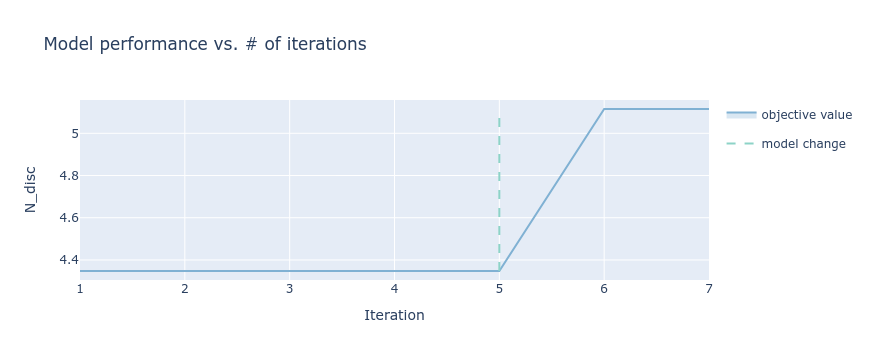

In [12]:
render(
    ax_client.get_optimization_trace()
)

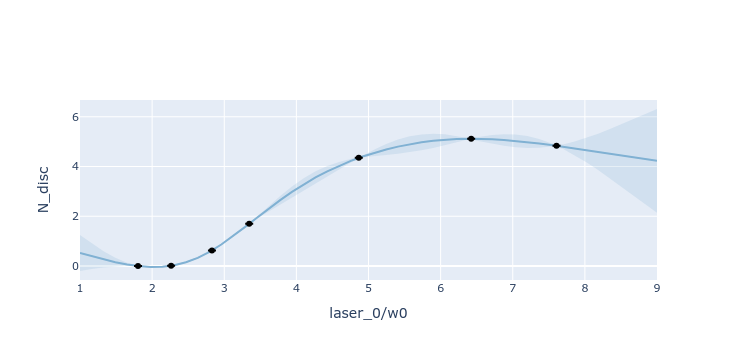

In [13]:
render(
    plot_slice(model, 'laser_0/w0',
               'N_disc')
)

## 3 pulse collision

### Optimization of thetas

#### Parameters

In [17]:
theta = 180
beta = 90

w0 = 3

laser_params = {
    'laser_0': {
        'tau': 25e-15,
        'lam': 800e-9,
        'w0': w0*800e-9,
        'W': 25,
        'E0': 1,
        'theta': 0,
        'phi': 0,
        'beta': 0,
        'solution': 'gaussian_paraxial'
    },
    'laser_1': {
        'tau': 25e-15,
        'lam': 800e-9,
        'w0': w0*800e-9,
        'W': 25,
        'E0': 1,
        'theta': 0,
        'phi': 180,
        'beta': 0,
        'solution': 'gaussian_paraxial'
    },
    'laser_2': {
        'tau': 25e-15,
        'lam': 800e-9,
        'w0': w0*800e-9,
        'W': 25,
        'E0': 1,
        'theta': theta,
        'phi': 0,
        'beta': beta,
        'solution': 'gaussian_paraxial'
    }
}

lam = 800e-9
scales = {
    'tau': 1e-15,
    'lam': lam,
    'w0': lam,
}

simbox_params = {
    'box_factors': {
        'long': 7,
        'trans': 15,
        't': 2
    },
    'resolutions': {
        'spatial': 2,
        't': 1
    }
}

save_path = f'{work_path}/ax_optimization/3_pulses/theta_all_w0_{w0}/'
Path(os.path.dirname(save_path)).mkdir(parents=True, exist_ok=True)

# Other parameters
default_params = {
    'laser_params': laser_params,
    'simbox_params': simbox_params,
    'scales': scales,
    'save_path': save_path,
    'geometry': 'xz',
    'low_memory_mode': False,
    'n_threads': 16,
    'pol_idx': 0,
    'discernible_spectral': False
}

yaml_path = f'{save_path}default_params.yml'
write_yaml(yaml_path, default_params)

In [18]:
optimization_params = {
    'name': f'3_pulses_theta',
    'n_trials': 20,
    'parameters': [
        {
            "name": "laser_0/theta",
            "type": "range",
            "bounds": [0., 90.],
            "value_type": "float",
        },
        {
            "name": "laser_1/theta",
            "type": "range",
            "bounds": [0., 90.],
            "value_type": "float",
        },
        {
            "name": "default_yaml",
            "type": "fixed",
            "value": yaml_path,
        },
    ],
    'objectives': [['N_disc', False]],
    'sbatch_params': {
        'slurm_partition': 'gpu',
        'cpus_per_task': 16,
        'slurm_mem': '60GB',
        'timeout_min': 120,
    }
}

optimization_yaml = f'{os.path.dirname(yaml_path)}/optimization.yml'
write_yaml(optimization_yaml, optimization_params)

#### Create bash script

In [19]:
# Create bash script
jobname = 'opt_3puls'
partition = 'gpu'
time = '10:00:00'
mem = '50GB'

script_path = f'{home_path}/cluster/ax_optimization_cluster.py'
script_kwargs = f'--params_yaml={optimization_yaml}'

bash = template.format(jobname=jobname,
                       partition=partition,
                       n_cpus=16,
                       time=time,
                       mem=mem,
                       env_name='lbl-botorch-test',
                       script_path=script_path,
                       script_kwargs=script_kwargs)

bash_path = f'{save_path}job.slurm'
with open(bash_path, 'w') as f:
    f.write(bash)

In [20]:
os.system(f'sbatch {bash_path}')

Submitted batch job 1054373


0

### Visualize results

In [33]:
save_path = f'{work_path}/ax_optimization/3_pulses/theta_all_w0_3/'
client_json = f'{save_path}experiment.json'
ax_client = (AxClient.load_from_json_file(client_json))
model = get_model_from_experiment(ax_client.experiment)

/home/wi73yus/.conda/envs/lbl-botorch-test/lib/python3.10/site-packages/ax/core/data.py:203: FutureWarning:

Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

/home/wi73yus/.conda/envs/lbl-botorch-test/lib/python3.10/site-packages/ax/core/data.py:203: FutureWarning:

Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

/home/wi73yus/.conda/envs/lbl-botorch-test/lib/python3.10/site-packages/ax/core/data.py:203: FutureWarning:

Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

/home/wi73yus/.conda/envs/lbl-botorch-test/lib/python3.10/site-packages/ax/core/data.py:203: FutureWarning:

Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read 

In [34]:
results = ax_client.generation_strategy.trials_as_df
results

[INFO 03-26 13:58:42] ax.modelbridge.generation_strategy: Note that parameter values in dataframe are rounded to 2 decimal points; the values in the dataframe are thus not the exact ones suggested by Ax in trials.


Generation Step Generation Model  Trial Index Trial Status  \
0   GenerationStep_0            Sobol            0    COMPLETED   
1   GenerationStep_0            Sobol            1    COMPLETED   
2   GenerationStep_0            Sobol            2    COMPLETED   
3   GenerationStep_0            Sobol            3    COMPLETED   
4   GenerationStep_0            Sobol            4    COMPLETED   
5   GenerationStep_1          BoTorch            5    COMPLETED   
6   GenerationStep_1          BoTorch            6    COMPLETED   
7   GenerationStep_1          BoTorch            7    COMPLETED   
8   GenerationStep_1          BoTorch            8    COMPLETED   
9   GenerationStep_1          BoTorch            9    COMPLETED   
10  GenerationStep_1          BoTorch           10    COMPLETED   
11  GenerationStep_1          BoTorch           11    COMPLETED   
12  GenerationStep_1          BoTorch           12    COMPLETED   
13  GenerationStep_1          BoTorch           13    COMPLETED   
14  GenerationStep_1          BoTorch           14    COMPLETED   
15  GenerationStep_1          BoTorch           15    COMPLETED   
16  GenerationStep_1          BoTorch           16    COMPLETED   
17  GenerationStep_1          BoTorch           17    COMPLETED   
18  GenerationStep_1          BoTorch           18    COMPLETED   
19  GenerationStep_1          BoTorch           19    COMPLETED   

                                Arm Parameterizations  
0   {'0_0': {'laser_0/theta': 33.85, 'laser_1/thet...  
1   {'1_0': {'laser_0/theta': 15.34, 'laser_1/thet...  
2   {'2_0': {'laser_0/theta': 65.04, 'laser_1/thet...  
3   {'3_0': {'laser_0/theta': 5.73, 'laser_1/theta...  
4   {'4_0': {'laser_0/theta': 5.11, 'laser_1/theta...  
5   {'5_0': {'laser_0/theta': 5.57, 'laser_1/theta...  
6   {'6_0': {'laser_0/theta': 0.0, 'laser_1/theta'...  
7   {'7_0': {'laser_0/theta': 0.0, 'laser_1/theta'...  
8   {'8_0': {'laser_0/theta': 90.0, 'laser_1/theta...  
9   {'9_0': {'laser_0/theta': 90.0, 'laser_1/theta...  
10  {'10_0': {'laser_0/theta': 68.05, 'laser_1/the...  
11  {'11_0': {'laser_0/theta': 0.0, 'laser_1/theta...  
12  {'12_0': {'laser_0/theta': 0.0, 'laser_1/theta...  
13  {'13_0': {'laser_0/theta': 49.73, 'laser_1/the...  
14  {'14_0': {'laser_0/theta': 90.0, 'laser_1/thet...  
15  {'15_0': {'laser_0/theta': 74.1, 'laser_1/thet...  
16  {'16_0': {'laser_0/theta': 37.42, 'laser_1/the...  
17  {'17_0': {'laser_0/theta': 55.16, 'laser_1/the...  
18  {'18_0': {'laser_0/theta': 48.13, 'laser_1/the...  
19  {'19_0': {'laser_0/theta': 35.28, 'laser_1/the...

In [35]:
trial_params = gather_trials_data(ax_client)
metrics = [(key,trial['N_disc']) for key,trial in trial_params.items()]
metrics

[(0, 0.0041782037),
 (1, 0.2248547707),
 (2, 0.0018534923),
 (3, 4.1877787194),
 (4, 0.019364538),
 (5, 1.6480472116),
 (6, 4.897170408),
 (7, 5.408817151),
 (8, 0.0088653812),
 (9, 1.9554164793000002),
 (10, 3.2898845001),
 (11, 5.6324683148),
 (12, 4.6649412425),
 (13, 4.8329056311),
 (14, 1.89086e-05),
 (15, 0.015062476600000001),
 (16, 5.2294764606),
 (17, 1.0615014975000001),
 (18, 0.0015248268),
 (19, 0.0012922016)]

In [36]:
ax_client.get_best_parameters()

/home/wi73yus/.conda/envs/lbl-botorch-test/lib/python3.10/site-packages/ax/modelbridge/transforms/winsorize.py:351: DeprecationWarning:

the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)

[WARNING 03-26 13:58:44] ax.modelbridge.cross_validation: Metric energy was unable to be reliably fit.


({'laser_0/theta': 0.0,
  'laser_1/theta': 42.20602491540813,
  'default_yaml': '/work/wi73yus/lbl-botorch-experiments/ax_optimization/3_pulses/theta_all_w0_3/default_params.yml'},
 ({'energy': 74.99999998361136,
   'N_disc': 5.632413535178965,
   'N_total': 43.21345028074964},
  {'energy': {'energy': 3.489438210566516e-09, 'N_disc': 0.0, 'N_total': 0.0},
   'N_disc': {'energy': 0.0, 'N_disc': 5.297861428606355e-06, 'N_total': 0.0},
   'N_total': {'energy': 0.0,
    'N_disc': 0.0,
    'N_total': 9.093816059387209e-05}}))

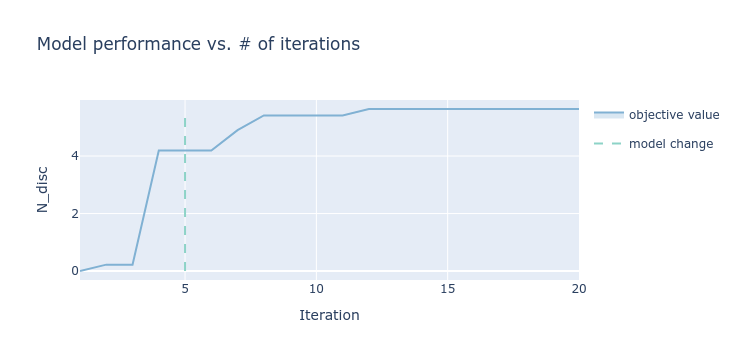

In [37]:
render(
    ax_client.get_optimization_trace()
)

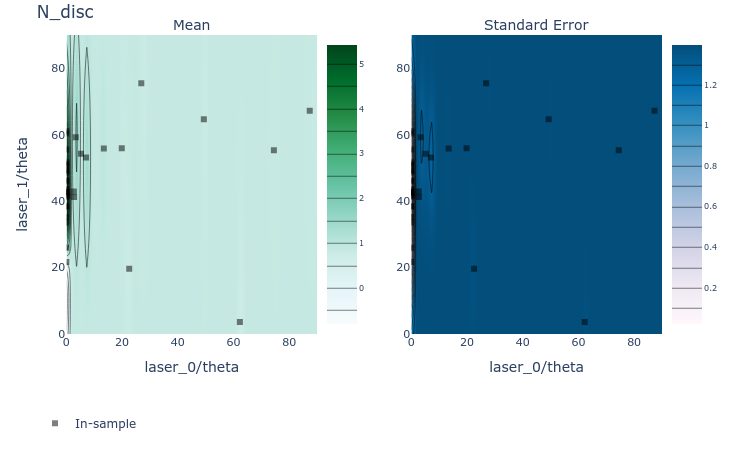

In [49]:
render(
    plot_contour(model, 'laser_0/theta', 'laser_1/theta',
                 'N_disc')
)

### Optimization of thetas and phis for two pulses

### Default parameters

In [35]:
theta = 180
beta = 90

w0 = 5

laser_params = {
    'laser_0': {
        'tau': 25e-15,
        'lam': 800e-9,
        'w0': w0*800e-9,
        'W': 25,
        'E0': 1,
        'theta': 0,
        'phi': 0,
        'beta': 0,
        'solution': 'gaussian_paraxial'
    },
    'laser_1': {
        'tau': 25e-15,
        'lam': 800e-9,
        'w0': w0*800e-9,
        'W': 25,
        'E0': 1,
        'theta': 0,
        'phi': 180,
        'beta': 0,
        'solution': 'gaussian_paraxial'
    },
    'laser_2': {
        'tau': 25e-15,
        'lam': 800e-9,
        'w0': w0*800e-9,
        'W': 25,
        'E0': 1,
        'theta': theta,
        'phi': 0,
        'beta': beta,
        'solution': 'gaussian_paraxial'
    }
}

lam = 800e-9
scales = {
    'tau': 1e-15,
    'lam': lam,
    'w0': lam,
}

simbox_params = {
    'box_factors': {
        'long': 7,
        'trans': 15,
        't': 2
    },
    'resolutions': {
        'spatial': 2,
        't': 1
    }
}

save_path = f'{work_path}/ax_optimization/3_pulses/theta_all_w0_{w0}/'
Path(os.path.dirname(save_path)).mkdir(parents=True, exist_ok=True)

# Other parameters
default_params = {
    'laser_params': laser_params,
    'simbox_params': simbox_params,
    'scales': scales,
    'save_path': save_path,
    'geometry': 'xz',
    'low_memory_mode': False,
    'n_threads': 16,
    'pol_idx': 0,
    'discernible_spectral': False
}

yaml_path = f'{save_path}default_params.yml'
write_yaml(yaml_path, default_params)

In [36]:
optimization_params = {
    'name': f'3_pulses_theta_phi',
    'n_trials': 20,
    'parameters': [
        {
            "name": "laser_1/theta",
            "type": "range",
            "bounds": [0., 90.],
            "value_type": "float",
        },
        {
            "name": "laser_0/theta",
            "type": "range",
            "bounds": [0., 90.],
            "value_type": "float",
        },
        {
            "name": "default_yaml",
            "type": "fixed",
            "value": yaml_path,
        },
    ],
    'objectives': [['N_disc', False]],
    'sbatch_params': {
        'slurm_partition': 'gpu',
        'cpus_per_task': 16,
        'slurm_mem': '70GB',
        'timeout_min': 120,
    }
}

optimization_yaml = f'{os.path.dirname(yaml_path)}/optimization.yml'
write_yaml(optimization_yaml, optimization_params)

### Bash script

In [37]:
# Create bash script
jobname = 'opt_3puls'
partition = 'gpu'
time = '10:00:00'
mem = '65GB'

script_path = f'{home_path}/cluster/ax_optimization_cluster.py'
script_kwargs = f'--params_yaml={optimization_yaml}'

bash = template.format(jobname=jobname,
                       partition=partition,
                       n_cpus=16,
                       time=time,
                       mem=mem,
                       env_name='lbl-botorch-test',
                       script_path=script_path,
                       script_kwargs=script_kwargs)

bash_path = f'{save_path}job.slurm'
with open(bash_path, 'w') as f:
    f.write(bash)

In [38]:
os.system(f'sbatch {bash_path}')

Submitted batch job 1055817


0

### Visualize results

In [39]:
save_path = f'{work_path}/ax_optimization/3_pulses/theta_all_w0_5/'
client_json = f'{save_path}experiment.json'
ax_client = (AxClient.load_from_json_file(client_json))
model = get_model_from_experiment(ax_client.experiment)

/home/wi73yus/.conda/envs/lbl-botorch-test/lib/python3.10/site-packages/ax/core/data.py:203: FutureWarning:

Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

/home/wi73yus/.conda/envs/lbl-botorch-test/lib/python3.10/site-packages/ax/core/data.py:203: FutureWarning:

Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

/home/wi73yus/.conda/envs/lbl-botorch-test/lib/python3.10/site-packages/ax/core/data.py:203: FutureWarning:

Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

/home/wi73yus/.conda/envs/lbl-botorch-test/lib/python3.10/site-packages/ax/core/data.py:203: FutureWarning:

Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read 

In [40]:
results = ax_client.generation_strategy.trials_as_df
results

[INFO 03-27 11:06:46] ax.modelbridge.generation_strategy: Note that parameter values in dataframe are rounded to 2 decimal points; the values in the dataframe are thus not the exact ones suggested by Ax in trials.


Generation Step Generation Model  Trial Index Trial Status  \
0   GenerationStep_0            Sobol            0    COMPLETED   
1   GenerationStep_0            Sobol            1    COMPLETED   
2   GenerationStep_0            Sobol            2    COMPLETED   
3   GenerationStep_0            Sobol            3    COMPLETED   
4   GenerationStep_0            Sobol            4    COMPLETED   
5   GenerationStep_1          BoTorch            5    COMPLETED   
6   GenerationStep_1          BoTorch            6    COMPLETED   
7   GenerationStep_1          BoTorch            7    COMPLETED   
8   GenerationStep_1          BoTorch            8    COMPLETED   
9   GenerationStep_1          BoTorch            9    COMPLETED   
10  GenerationStep_1          BoTorch           10    COMPLETED   
11  GenerationStep_1          BoTorch           11    COMPLETED   
12  GenerationStep_1          BoTorch           12    COMPLETED   
13  GenerationStep_1          BoTorch           13    COMPLETED   
14  GenerationStep_1          BoTorch           14    COMPLETED   
15  GenerationStep_1          BoTorch           15    COMPLETED   
16  GenerationStep_1          BoTorch           16    COMPLETED   
17  GenerationStep_1          BoTorch           17    COMPLETED   
18  GenerationStep_1          BoTorch           18    COMPLETED   
19  GenerationStep_1          BoTorch           19    COMPLETED   

                                Arm Parameterizations  
0   {'0_0': {'laser_1/theta': 29.24, 'laser_0/thet...  
1   {'1_0': {'laser_1/theta': 54.91, 'laser_0/thet...  
2   {'2_0': {'laser_1/theta': 23.44, 'laser_0/thet...  
3   {'3_0': {'laser_1/theta': 64.44, 'laser_0/thet...  
4   {'4_0': {'laser_1/theta': 57.45, 'laser_0/thet...  
5   {'5_0': {'laser_1/theta': 20.66, 'laser_0/thet...  
6   {'6_0': {'laser_1/theta': 3.77, 'laser_0/theta...  
7   {'7_0': {'laser_1/theta': 34.94, 'laser_0/thet...  
8   {'8_0': {'laser_1/theta': 36.28, 'laser_0/thet...  
9   {'9_0': {'laser_1/theta': 31.6, 'laser_0/theta...  
10  {'10_0': {'laser_1/theta': 47.75, 'laser_0/the...  
11  {'11_0': {'laser_1/theta': 0.0, 'laser_0/theta...  
12  {'12_0': {'laser_1/theta': 90.0, 'laser_0/thet...  
13  {'13_0': {'laser_1/theta': 29.37, 'laser_0/the...  
14  {'14_0': {'laser_1/theta': 74.53, 'laser_0/the...  
15  {'15_0': {'laser_1/theta': 31.61, 'laser_0/the...  
16  {'16_0': {'laser_1/theta': 28.13, 'laser_0/the...  
17  {'17_0': {'laser_1/theta': 34.37, 'laser_0/the...  
18  {'18_0': {'laser_1/theta': 27.05, 'laser_0/the...  
19  {'19_0': {'laser_1/theta': 26.21, 'laser_0/the...

In [41]:
trial_params = gather_trials_data(ax_client)
metrics = [(key,trial['N_disc']) for key,trial in trial_params.items()]
metrics

[(0, 0.1746700725),
 (1, 0.0006516117),
 (2, 0.0018841166000000001),
 (3, 0.0027058648),
 (4, 0.000652854),
 (5, 0.9199486982),
 (6, 0.039888529000000006),
 (7, 0.8216439063000001),
 (8, 0.1463275172),
 (9, 0.9798359332000001),
 (10, 0.8177467334),
 (11, 0.3361088727),
 (12, 0.3644828372),
 (13, 1.0058543133),
 (14, 0.0006670368),
 (15, 0.9633008200000001),
 (16, 1.016967106),
 (17, 0.9318659636000001),
 (18, 1.0637789913),
 (19, 1.0704967416)]

In [42]:
ax_client.get_best_parameters()

/home/wi73yus/.conda/envs/lbl-botorch-test/lib/python3.10/site-packages/ax/modelbridge/transforms/winsorize.py:351: DeprecationWarning:

the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)

[WARNING 03-27 11:06:56] ax.modelbridge.cross_validation: Metric energy was unable to be reliably fit.


({'laser_1/theta': 26.212236470403745,
  'laser_0/theta': 1.1636143109742503,
  'default_yaml': '/work/wi73yus/lbl-botorch-experiments/ax_optimization/3_pulses/theta_all_w0_5/default_params.yml'},
 ({'N_total': 6.965661182656911,
   'energy': 75.00000127825835,
   'N_disc': 1.0704561229607545},
  {'N_total': {'N_total': 1.537525186701798e-06, 'energy': 0.0, 'N_disc': 0.0},
   'energy': {'N_total': 0.0, 'energy': 4.0573244328246274e-10, 'N_disc': 0.0},
   'N_disc': {'N_total': 0.0,
    'energy': 0.0,
    'N_disc': 2.0420645704022103e-07}}))

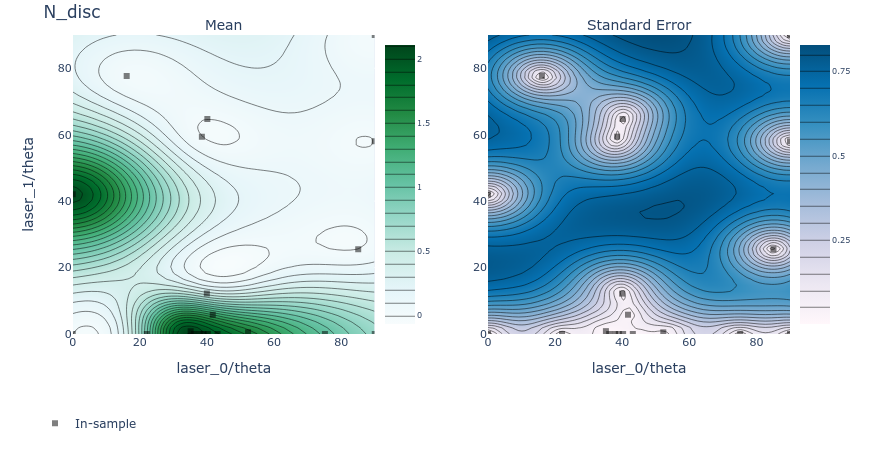

In [25]:
render(
    plot_contour(model, 'laser_0/theta', 'laser_1/theta',
                 'N_disc')
)

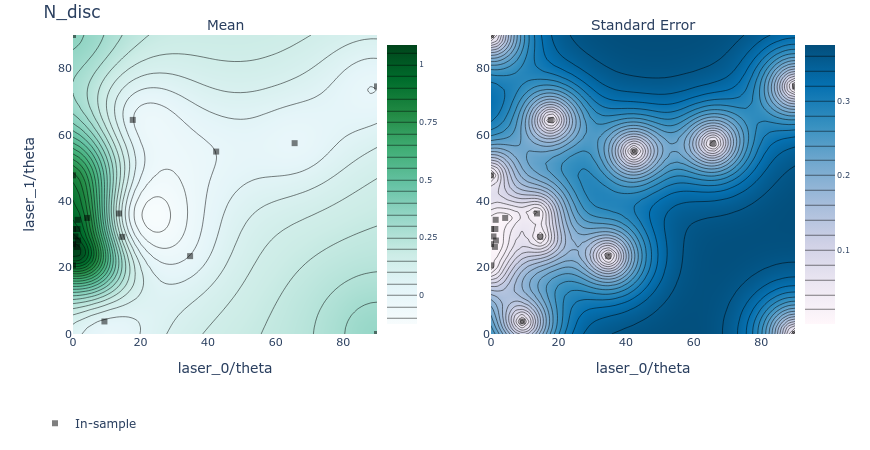

In [43]:
render(
    plot_contour(model, 'laser_0/theta', 'laser_1/theta',
                 'N_disc')
)

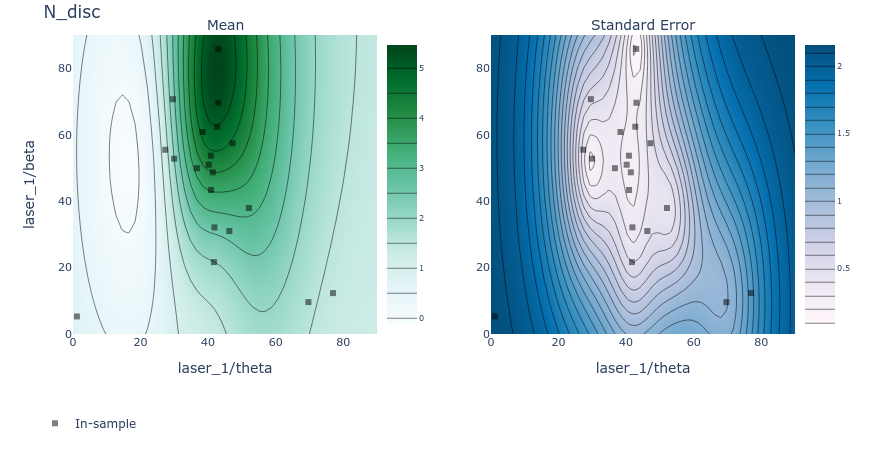

In [33]:
render(
    plot_contour(model, 'laser_1/theta', 'laser_1/beta',
                 'N_disc')
)

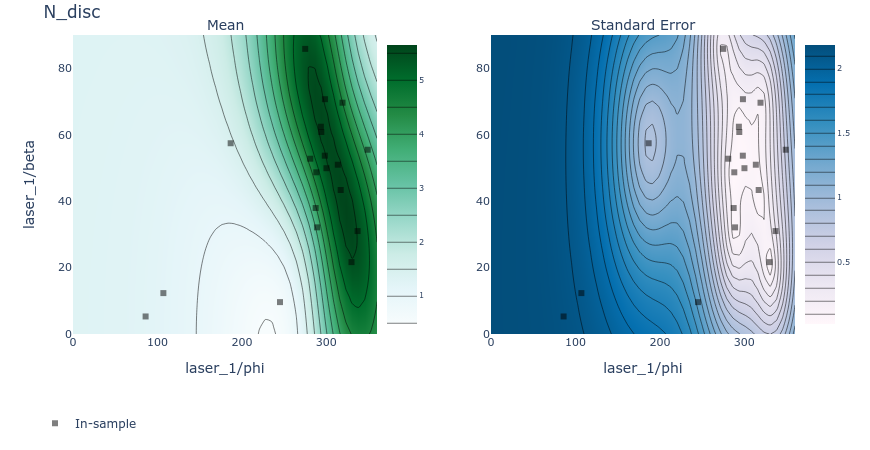

In [34]:
render(
    plot_contour(model, 'laser_1/phi', 'laser_1/beta',
                 'N_disc')
)

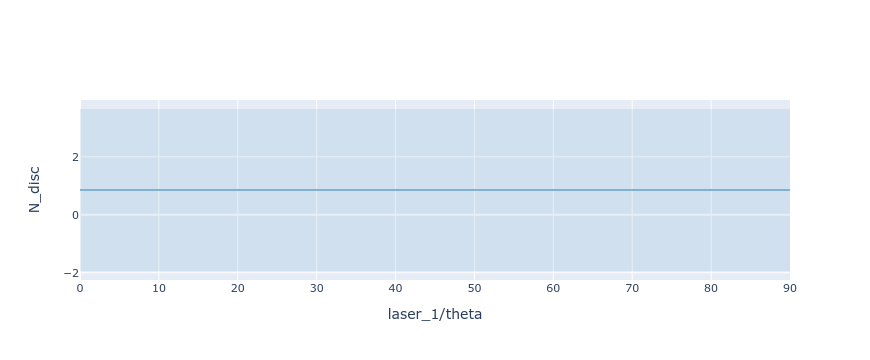

In [62]:
render(
    plot_slice(model, 'laser_1/theta',
               'N_disc')
)